# TODO my changes to keep really short syllables and not discard low saliency syllables was discarded so I need to reimpliment them!!!!
## Read biosound H5 files and cluster
### After sorting some syllables/notes/calls in SoundSep you must first calculate spectral/temporal features of them with Biosound and store those features as H5 files. This is all done with save_biosound_h5files.ipynb.
### This notebook takes the H5 files, makes a Pandas DF, and does some clustering on them.

In [2]:
# from scipy import integrate, optimize

from scipy.signal import spectrogram, butter, sosfilt, sosfiltfilt, correlate
from scipy.io.wavfile import read, write
import IPython.display as ipd
# import sys
from collections import Counter
import os
import pandas as pd
# import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import pickle
import csv
from soundsig.sound import BioSound 
from soundsig.sound import WavFile

# Dimension reduction and clustering libraries
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA



# from ipywidgets import interact, fixed
# from ipywidgets import widgets
import matplotlib.pyplot as plt

def plot_a_spectrogram(w, fs:int=48000, title:str=spectrogram, nfft:int=2048):
    ff, tt, Sxx = spectrogram(w, fs=fs, nfft=nfft)
    max_ff = 10000 # only plot the first 10kHz
    ff_index = np.where(ff < max_ff)
    ff = ff[ff_index]
    Sxx = Sxx[ff_index]

    plt.figure(figsize=(10, 5))
    plt.pcolormesh(tt, ff[:max_ff], Sxx[:max_ff], cmap='plasma', shading='auto')
    # plt.pcolormesh(tt, ff[:145], Sxx[:145], cmap='plasma', shading='gouraud')
    plt.title(title)
    plt.xlabel('t (sec)')
    plt.ylabel('Frequency (Hz)')
    plt.grid()


def print_missing_features(X, XFeatureNames, indBad):
    missing_features = list()
    for feature in XFeatureNames:
        num_missing=0
        for i in indBad: 
            if np.isnan(X[i,np.where(XFeatureNames == feature)[0][0]]):
                num_missing += 1
        if num_missing > 0: print(f'num missing {feature} = {num_missing}')

In [3]:
base_folder = "/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023"# _Maeves_data"
h5_folder = 'h5filesAmp'

fs = 48000 # TODO find where to import fs instead of hardcoding it

os.chdir(os.path.join(base_folder, h5_folder))
print(os.getcwd())
files_list = os.listdir('.')
print(f'num files = {len(files_list)}, files_list[0] = {files_list[0]}')

/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/h5filesAmp
num files = 4345, files_list[0] = bird_WhiWhi6607F_call_["0"]_1134.h5


In [76]:
# Testing with one file
fname = files_list[1]

myBioSound = BioSound()
myBioSound.readh5(fname)
        
# Take the time average formants 
meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
        
# These are our two identifier - the emitter (bird) and the call type
Bird = np.array2string(myBioSound.emitter)[2:-1]
callType = np.array2string(myBioSound.type)[2:-1]

print("The following values shouldn't be NaN or 0")
print(f'meanF1 = {meanF1}, meanF2 = {meanF2}, meanF3 = {meanF3}, Bird = {Bird}, callType = {callType}')

The following values shouldn't be NaN or 0
meanF1 = 1223.1475918116207, meanF2 = 4405.922739456839, meanF3 = 9015.34493500762, Bird = BluGre1214F, callType = ["6"]


In [79]:
import soundsig
soundsig.__file__

'/opt/miniconda3/lib/python3.9/site-packages/soundsig/__init__.py'

## If you have previously saved a pandas df from the H5 files you can skip the next two cells

In [4]:
# # vocSelData is going to be a list of dictionary containing the values that we are going to extract from each BioSound object.
# vocSelData = []

# # Looping through all the files
# i = 0
# for fname in files_list:
#     if fname.endswith('.h5'):
#         # print(f'index = {i}, fname = {fname}')
#         # print(fname)
#         # Allocate object and read data
#         myBioSound = BioSound()
#         try:
#             myBioSound.readh5(fname)
#         except:
#             print('Could not read h5 file', fname)
#             continue
        
#         # These are our two identifier - the emitter (bird) and the call type
#         Bird = np.array2string(myBioSound.emitter)[2:-1]
#         callType = np.array2string(myBioSound.type)[2:-1]

#         # Get values for the fundamental
#         if myBioSound.fund.size > 0:
#             fund = float(myBioSound.fund)
#             cvfund = float(myBioSound.cvfund)
#             maxfund = float(myBioSound.maxfund)
#             minfund = float(myBioSound.minfund)
#             devfund = np.nanmean(np.diff(myBioSound.f0))
#                     # Take the time average formants 
#             meanF1 = np.mean(myBioSound.F1[~np.isnan(myBioSound.F1)])
#             meanF2 = np.mean(myBioSound.F2[~np.isnan(myBioSound.F2)])
#             meanF3 = np.mean(myBioSound.F3[~np.isnan(myBioSound.F3)])
#         else:
#             fund = -10 
#             cvfund = 0   
#             maxfund = 0
#             # TODO add default value of devfund
#             # TODO just notes here: play with UMAP neighborhood.
#             # TODO play with HDBScan neighborhood. fit it. silhouette score. davis dun score. 
#             # TODO # of unclassified calls.
#             # TODO try to classifiy noise vs calls. force 2 clusters.
#             # then look at soundsep. 
#             minfund = 0
#             devfund = 0
#             meanF1 = 0
#             meanF2 = 0
#             meanF3 = 0
            

#         vocSelData.append({"Bird": Bird, 
#                      "project.start_index": int(fname.split('.')[0].split('_')[-1]),
#                      "calltype": callType, 
#                      "fund": fund, "devfund": devfund,
#                      "cvfund": cvfund, "maxfund": maxfund, "minfund": minfund,
#                      "F1": meanF1, "F2": meanF2, "F3":meanF3,
#                      "sal": float(myBioSound.meansal), 
#                      "rms": float(myBioSound.rms), 
#                      "maxAmp": float(myBioSound.maxAmp),
#                      "meanS": float(myBioSound.meanspect), "stdS": float(myBioSound.stdspect),
#                      "skewS": float(myBioSound.skewspect), "kurtS": float(myBioSound.kurtosisspect), 
#                      "entS": float(myBioSound.entropyspect),
#                      "q1": float(myBioSound.q1), "q2": float(myBioSound.q2), "q3": float(myBioSound.q3),                  
#                      "meanT": float(myBioSound.meantime), "stdT": float(myBioSound.stdtime),
#                      "skewT": float(myBioSound.skewtime), "kurtT": float(myBioSound.kurtosistime),
#                      "entT": float(myBioSound.entropytime)
        
# })
#         i += 1
#         if ((i % 1000) == 0):
#             print('Done with', i, 'files')
#         #if (i == 10000):
#             #break

# print(f'Done with {i} files')


/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [5]:
# Write the results to a pandas df

# tableStore = os.path.join(base_folder,'vocSelTableAmp.h5')
# vocSelTable = pd.DataFrame(vocSelData)
# vocSelTable.to_hdf(tableStore, 'callTable', mode = 'w')

## If you already stored the H5 file just load it, skipping the above cells
## Either way, at this point we will also need to load the soundsep syllable csv from a couple steps up the pipeline

In [6]:
# You can also start the script here and skip the reading of h5 files and creation of table
# Read the vocSelTable
vocSelTable = pd.read_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5')) # haven't tried this yet
print(f"loading file: {os.path.join(base_folder, 'vocSelTableAmp.h5')} with {len(vocSelTable)} syllables")

loading file: /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/vocSelTableAmp.h5 with 4344 syllables


In [7]:
# Read the annotated syllabes.csv file to get information on solo vs overlap and what tags were manually entered
syll_file_name = os.path.join(base_folder,'_appdata','save','segments.csv')
backup_name = os.path.join(base_folder,'_appdata','save','segments_backup_good.csv')
syllTable = pd.read_csv(backup_name, sep=',',header=0) 
print(f"loading {syll_file_name} with {len(syllTable)} syllables")

birds = np.unique(vocSelTable['Bird'])
print(f'birds = {birds}')

loading /Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/_appdata/save/segments.csv with 4344 syllables
birds = ['BluGre1214F' 'BroGre1354M' 'WhiWhi1541M' 'WhiWhi6607F']


In [8]:
# we may want to merge the syllTable and the vocSelTable, let's verify that the indices are the same
if np.array_equal(vocSelTable.index, syllTable.index):
    print(f'The indices are the same ({len(vocSelTable.index)} long), merging the tables')
    vocSelTableFull = pd.concat([vocSelTable, syllTable], axis=1)   
else:
    print('The indices are not the same')

The indices are the same (4344 long), merging the tables


In [9]:
# These values should look reasonable
vocSelTableFull

,Bird,project.start_index,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,...,skewT,kurtT,entT,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster
0,WhiWhi6607F,1134,"[""0""]",602.035277,0.020312,0.123225,676.056338,480.000000,1927.151857,5606.097997,...,-0.031718,2.037413,0.966456,0,BroGre1354M,0,705034,709502,"[""1""]",0.0
1,BluGre1214F,951,"[""6""]",532.179639,0.659361,0.171370,592.592593,298.136646,1223.147592,4405.922739,...,-0.048306,1.941768,0.994068,1,BluGre1214F,2,739121,741816,"[""6""]",5.0
2,BluGre1214F,3202,"[""5""]",1004.070215,-1.918334,1.029701,3428.571429,539.325843,3282.440047,5674.842286,...,-0.066505,1.931446,0.993494,2,BluGre1214F,2,773851,776369,"[""2""]",1.0
3,WhiWhi6607F,2406,"[""6""]",606.338279,0.138851,0.031357,631.578947,564.705882,1153.195682,2492.185919,...,-0.015422,1.876354,0.998047,3,BluGre1214F,2,844891,848558,"[""6""]",5.0
4,BroGre1354M,311,"[""5""]",538.920136,0.645045,0.054985,564.705882,484.848485,2085.536237,3634.836575,...,-0.036766,1.929756,0.993356,4,BroGre1354M,0,910549,913839,"[""5""]",4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,264,"[""5""]",2759.790084,88.223783,0.410419,3428.571429,640.000000,3032.627721,4153.134038,...,-0.194618,2.214188,0.981780,4339,WhiWhi1541M,3,297302736,297305283,"[""5""]",4.0
4340,WhiWhi6607F,2596,"[""6""]",578.539703,-0.142540,0.253493,705.882353,342.857143,2424.752958,4687.304451,...,0.001646,1.840979,0.998115,4340,BluGre1214F,2,297324812,297329004,"[""6""]",5.0
4341,WhiWhi6607F,2607,"[""6""]",549.876920,-0.126703,0.223594,640.000000,317.880795,1243.568203,2839.879516,...,0.006879,1.913242,0.995226,4341,BluGre1214F,2,297367001,297371644,"[""6""]",5.0
4342,BluGre1214F,453,"[""6""]",553.899881,-2.095338,0.032359,578.313253,521.739130,2318.997973,4615.010937,...,0.009932,1.831353,0.990856,4342,BluGre1214F,2,298070022,298074525,"[""6""]",5.0


In [10]:
# print the columns of vocSelTableFull
print(vocSelTableFull.columns)
print(f'len(vocSelTableFull) = {len(vocSelTableFull)}')

Index(['Bird', 'project.start_index', 'calltype', 'fund', 'devfund', 'cvfund',
       'maxfund', 'minfund', 'F1', 'F2', 'F3', 'sal', 'rms', 'maxAmp', 'meanS',
       'stdS', 'skewS', 'kurtS', 'entS', 'q1', 'q2', 'q3', 'meanT', 'stdT',
       'skewT', 'kurtT', 'entT', 'Unnamed: 0', 'SourceName', 'SourceChannel',
       'StartIndex', 'StopIndex', 'Tags', 'cluster'],
      dtype='object')
len(vocSelTableFull) = 4344


In [11]:
# figure out why my call lenghts are so long
# first write a few startindex and stopindex
print(vocSelTableFull['StartIndex'].head())
print(vocSelTableFull['StopIndex'].head())

0    705034
1    739121
2    773851
3    844891
4    910549
Name: StartIndex, dtype: int64
0    709502
1    741816
2    776369
3    848558
4    913839
Name: StopIndex, dtype: int64


['["1"]' '["6"]' '["2"]' '["5"]' '["0"]' '["4"]' '["3"]' '[]']
['1' '6' '2' '5' '0' '4' '3' '']


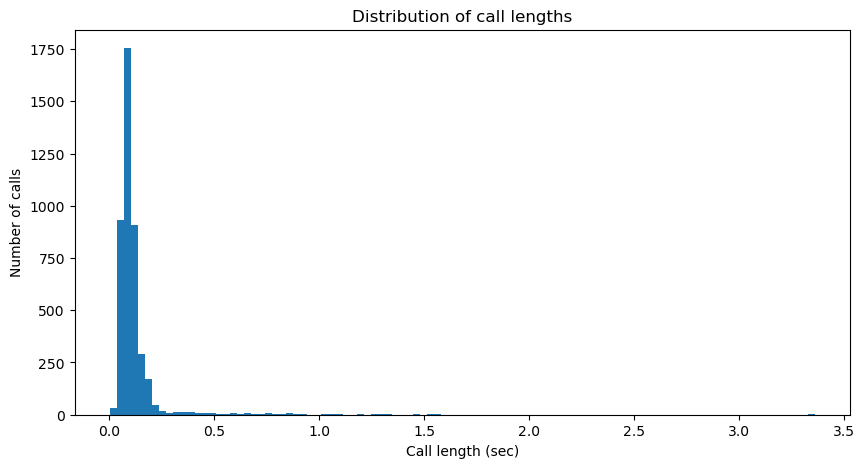

In [12]:
# calculate the length of each call
vocSelTableFull['callLength'] = (vocSelTableFull['StopIndex'] - vocSelTableFull['StartIndex']) / fs
 
# plot the distribution of call lengths
plt.figure(figsize=(10, 5))
plt.hist(vocSelTableFull['callLength'], bins=100)
plt.xlabel('Call length (sec)')
plt.ylabel('Number of calls')
plt.title('Distribution of call lengths')

# The tags have extra characters that I don't want
print(vocSelTableFull['Tags'].unique())
# it appears they have a '[""]' surrounding them
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')
print(vocSelTableFull['Tags'].unique())
# change the tags column of the df to the stripped version
vocSelTableFull['Tags'] = vocSelTableFull['Tags'].str.strip('[""]')

## Now we are going to rearrange the data to do a UMAP projection.
## This requires:
## - taking only some features
## - excluding any rows with NaNs
## - TODO don't lose the NANs so my index isn't wrong
## - zscore and then calculate PCAs
## - we may also may withhold some data to verify our sorting (not now though)

In [13]:
# Generate the data array of biosound features
# X is the data array of features.
startFeat = 3
endFeat = 10
startFeat2 = 11
endFeat2 = 27
# note I added callLength to the features, which is the last one
salInd = 7

XFeatureNames = np.array(np.hstack((vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:])))
print('Features chosen:', XFeatureNames)
nfeatures = len(XFeatureNames)

Features chosen: ['fund' 'devfund' 'cvfund' 'maxfund' 'minfund' 'F1' 'F2' 'sal' 'rms'
 'maxAmp' 'meanS' 'stdS' 'skewS' 'kurtS' 'entS' 'q1' 'q2' 'q3' 'meanT'
 'stdT' 'skewT' 'kurtT' 'entT' 'callLength']


In [72]:
# Generate the data array of biosound features
# X is the data array of features.
# XFeatureNames = np.array(np.hstack([vocSelTableFull.columns[startFeat:endFeat],vocSelTableFull.columns[startFeat2:endFeat2],vocSelTableFull.columns[-1:]]))
# print('Features chosen:', XFeatureNames)
# nfeatures = len(XFeatureNames)

XBirds = []
indGoodBirds = []
infoBirds = []
nsyllBirds = []
    
X = np.hstack([vocSelTableFull.iloc[:,startFeat:endFeat],vocSelTableFull.iloc[:,startFeat2:endFeat2],vocSelTableFull.iloc[:,-1:]])

# Find the rows that have the full data set
indGood = np.where((np.sum(np.invert(np.isnan(X)), axis=1) == nfeatures) & (X[:,salInd]>0.3))[0]
indBad = np.where((np.sum(np.invert(np.isnan(X)), axis=1) != nfeatures) | (X[:,salInd]<=0.3))[0]
# print(f'badfiles = {indBad}')
indGoodBirds.append(indGood)

# print('nsyll=', len(indGood), '/', X.shape[0])
nsyllBirds.append(len(indGood))
# How many rows are we losing?
print('Number of rows lost:', X.shape[0] - len(indGood))
print('Out of how many rows?', X.shape[0])

# calculate which features are contributing to the missing data
# def print_missing_features(X, XFeatureNames, indBad):
#     missing_features = list()
#     for feature in XFeatureNames:
#         num_missing=0
#         for indBad in indBad: 
#             if np.isnan(X[indBad,np.where(XFeatureNames == feature)[0][0]]):
#                 num_missing += 1
#         if num_missing > 0: print(f'num missing {feature} = {num_missing}')

print_missing_features(X, XFeatureNames, indBad)

cleanX = X[indGood,:]
cleanTags = vocSelTableFull.iloc[indGood,0:3]
print('dimensions of cleanX:', cleanX.shape)
# print cleantages unique
print('unique call types:', np.unique(cleanTags['calltype']))


Number of rows lost: 103
Out of how many rows? 4344
num missing devfund = 2
num missing F2 = 2
dimensions of cleanX: (4241, 24)
unique call types: ['["0"]' '["1"]' '["2"]' '["3"]' '["4"]' '["5"]' '["6"]' '[]']


In [15]:
files_list[19]

'bird_WhiWhi6607F_call_["0"]_1196.h5'

In [16]:
# print the names of h5 files with bad indexes
for ind in indBad[0:10]:
    print(f'bad files names = {files_list[ind]}, index = {ind}')

bad files names = bird_WhiWhi6607F_call_["0"]_1134.h5, index = 0
bad files names = bird_WhiWhi1541M_call_["0"]_3465.h5, index = 5
bad files names = bird_WhiWhi1541M_call_["0"]_1178.h5, index = 81
bad files names = bird_WhiWhi6607F_call_["0"]_2932.h5, index = 115
bad files names = bird_BroGre1354M_call_["0"]_2961.h5, index = 156
bad files names = bird_BroGre1354M_call_["0"]_849.h5, index = 159
bad files names = bird_WhiWhi1541M_call_["0"]_2032.h5, index = 186
bad files names = bird_WhiWhi1541M_call_["0"]_679.h5, index = 194
bad files names = bird_WhiWhi1541M_call_["0"]_1455.h5, index = 248
bad files names = bird_WhiWhi1541M_call_["0"]_3550.h5, index = 250


Shape of Z_PCA_All: (4241, 10)


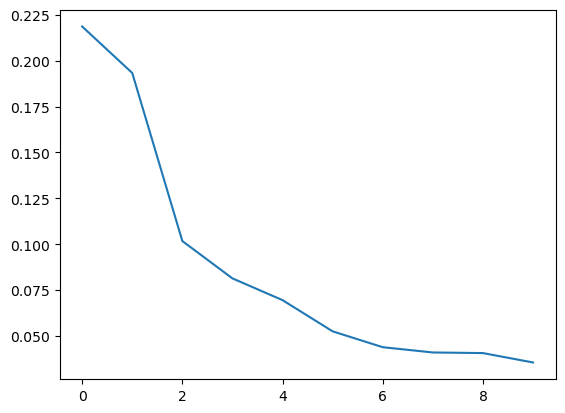

In [17]:
# Zscore the data
meanBalancedAll = np.mean(cleanX, axis = 0)
sdBalancedAll = np.std(cleanX, axis = 0, ddof=1)
ZBalancedAll = (cleanX - meanBalancedAll)/sdBalancedAll

# PCA the data
pcaBalanced = PCA(n_components=10, svd_solver='full')
Z_PCA_Balanced_All = pcaBalanced.fit_transform(ZBalancedAll)

print("Shape of Z_PCA_All:", Z_PCA_Balanced_All.shape)

# Plot the explainable variance
plt.plot(pcaBalanced.explained_variance_ratio_)

(4241, 10)


Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

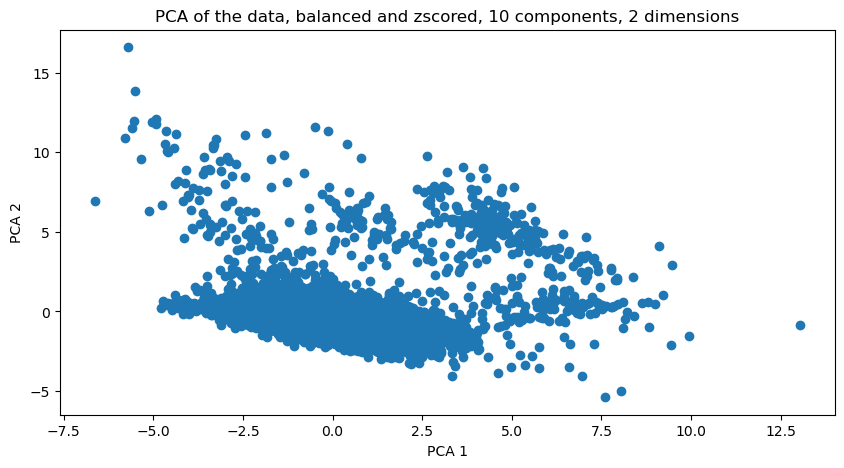

In [18]:
print(Z_PCA_Balanced_All.shape)
# Plot the first two components
plt.figure(figsize=(10, 5))
plt.scatter(Z_PCA_Balanced_All[:,0], Z_PCA_Balanced_All[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')


In [19]:
# Take the z-scored PCA data and run UMAP on it

MAXSYLL = 40
umapFit = umap.UMAP(
        n_neighbors=int(len(Z_PCA_Balanced_All)/MAXSYLL),
        min_dist=0.1,
        n_components=3,
        random_state=42).fit(Z_PCA_Balanced_All)

umapAll = umapFit.transform(Z_PCA_Balanced_All)

# umapAllData = umapFit.transform(Z_PCA_Balanced_All)

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [20]:
# unique tags
print('unique tags:', np.unique(cleanTags['calltype']))


unique tags: ['["0"]' '["1"]' '["2"]' '["3"]' '["4"]' '["5"]' '["6"]' '[]']


Text(0.5, 1.0, 'UMAP colored by soundsep defined call type')

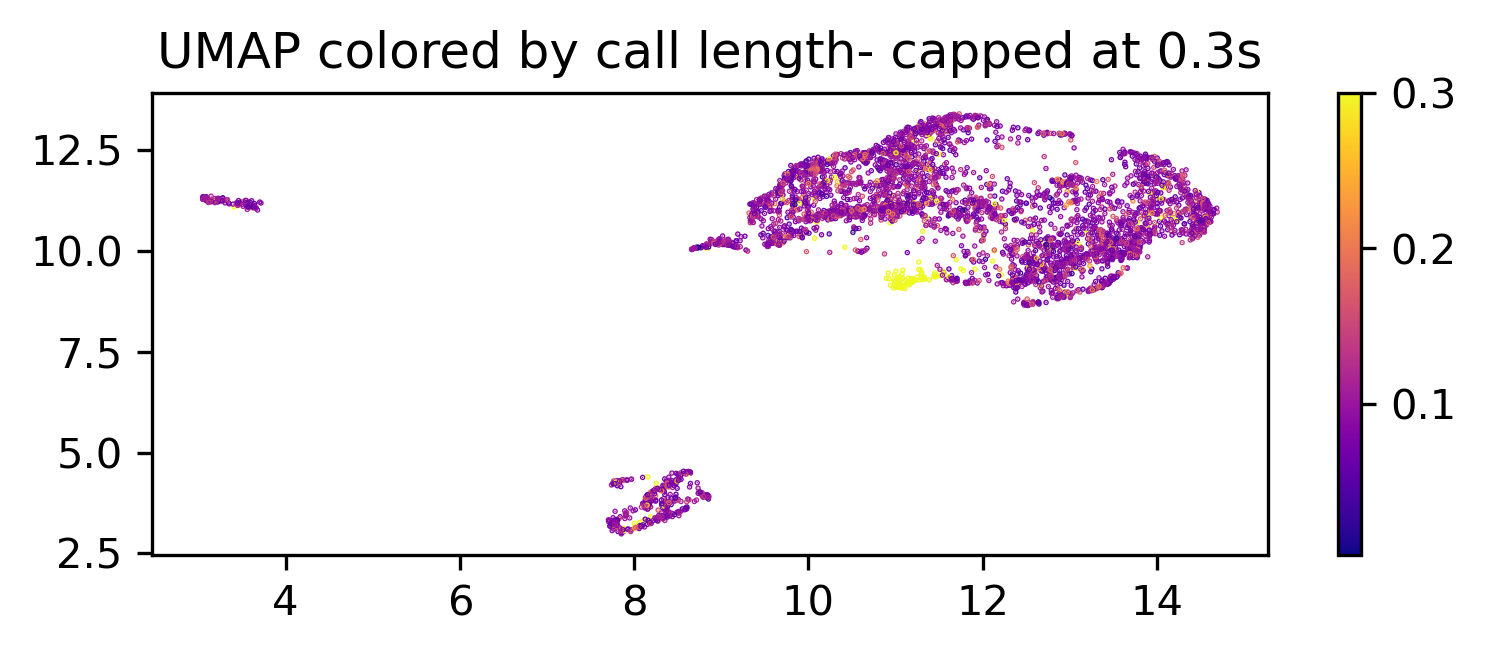

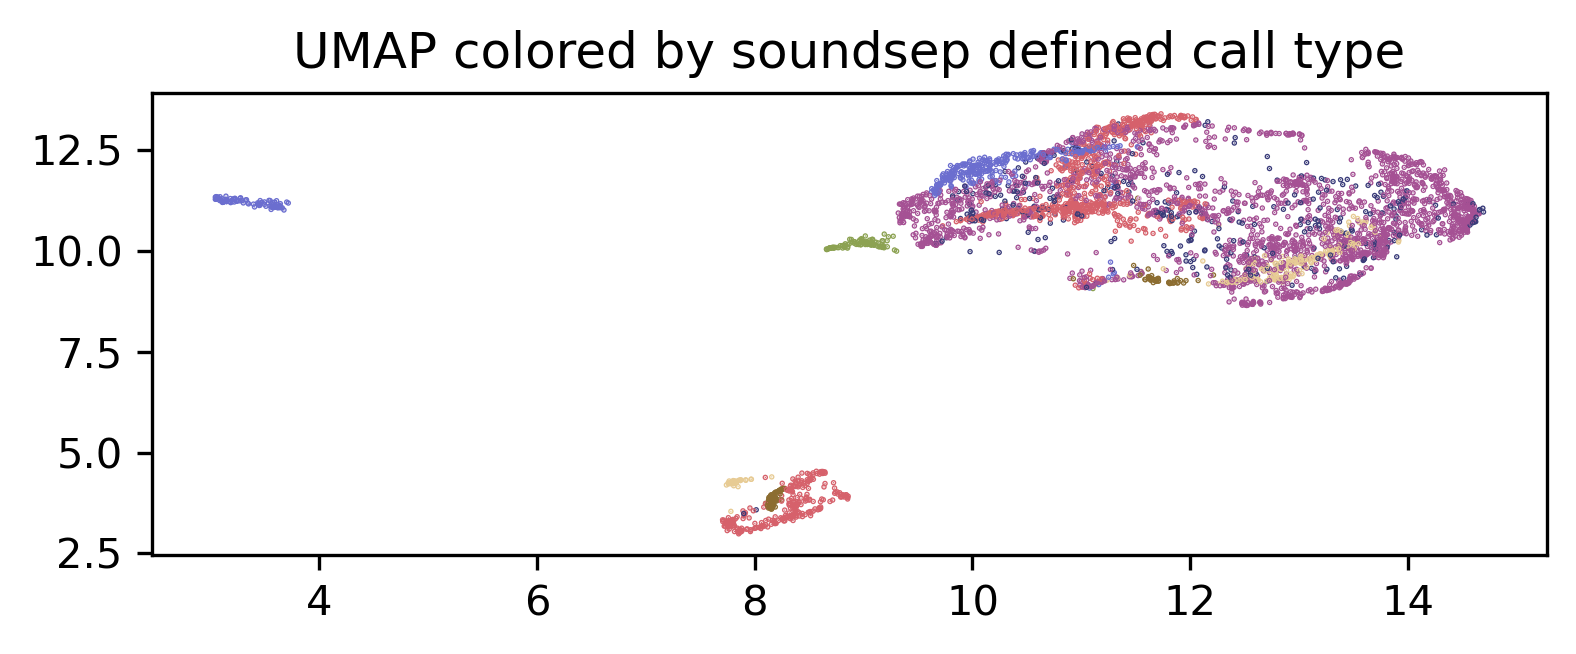

In [21]:
# shift the color index so that 0-.5s contains most of the color range.
# and plot the umap

c=cleanX[:,-1]
c[c>.3]=.3
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=c, cmap='plasma')
plt.title('UMAP colored by call length- capped at 0.3s')
plt.colorbar()

# plot the UMAP and color by the original tags of the call type
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=cleanTags['calltype'].astype('category').cat.codes, cmap='tab20b')
plt.title('UMAP colored by soundsep defined call type')



In [22]:
# Let's cluster the UMAP data
# HDBSCAN
min_cluster_size = 15
min_samples = 15
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
clusterer.fit(umapAll)


HDBSCAN(min_cluster_size=15, min_samples=15)

seems like my segments.csv file already has tags, figure this out

## Now let's use some clustering algorithms to assign new tags to our data.
## Afterwards we can re-save the SoundSep tags and look at the syllables there

Counter({7: 3276, 6: 287, 3: 258, 2: 101, 1: 97, 5: 87, 0: 85, 4: 29, -1: 21})


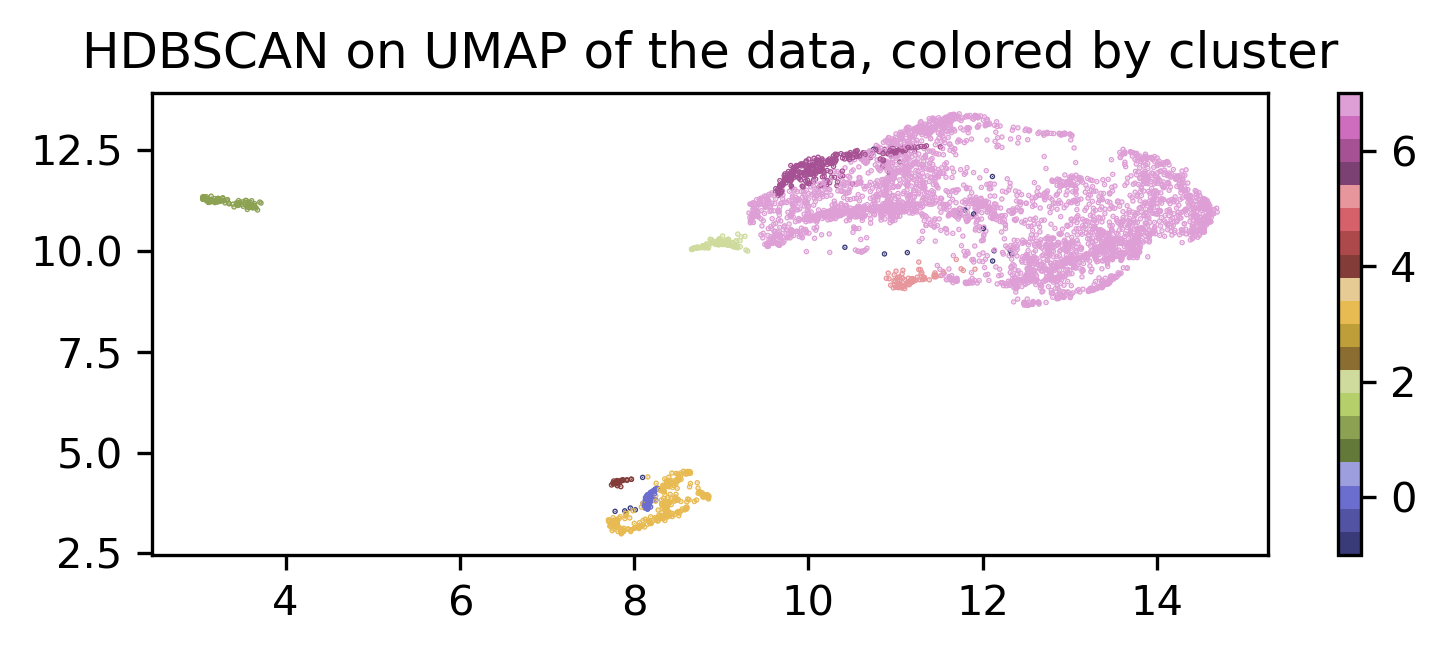

In [23]:
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()

#print the number data points in each cluster
print(Counter(clusterer.labels_))

In [24]:
# print the number of calls in each cluster and the unclassified
print('Number of calls in each cluster and the unclassified')
print(Counter(clusterer.labels_))



Number of calls in each cluster and the unclassified
Counter({7: 3276, 6: 287, 3: 258, 2: 101, 1: 97, 5: 87, 0: 85, 4: 29, -1: 21})


In [61]:
vocSelTableFull.iloc[0]

Bird                   WhiWhi6607F
project.start_index           1134
calltype                     ["0"]
fund                    602.035277
devfund                   0.020312
cvfund                    0.123225
maxfund                 676.056338
minfund                      480.0
F1                     1927.151857
F2                     5606.097997
F3                     8855.267795
sal                       0.292471
rms                       0.020452
maxAmp                    0.050164
meanS                  1424.183158
stdS                   1252.483367
skewS                     2.659343
kurtS                    13.084285
entS                      0.754326
q1                         609.375
q2                         1031.25
q3                          1875.0
meanT                     0.139157
stdT                      0.077088
skewT                    -0.031718
kurtT                     2.037413
entT                      0.966456
Unnamed: 0                       0
SourceName          

In [71]:
# plot some spectrograms from each cluster
# get the indices of the calls in each cluster
# cluster 0
for cluster_num in clusterer.labels_:
    print(f'cluster_num = {cluster_num}')
    cluster_indices = np.where(clusterer.labels_ == cluster_num)
    print(f'cluster_indices = {cluster_indices}')
    # get the first 5 calls in the cluster
    for i in range(5):
        # print(f'cluster {cluster_num}, call {i}')
        # print(f'index = {cluster_indices[0][i]}')
        print(f'raw file name = {files_list[cluster_indices[0][i]]}')
        # print(f'call type = {vocSelTableFull.iloc[cluster_indices[0][i],2]}')
        # print(f'bird = {vocSelTableFull.iloc[cluster_indices[0][i],0]}')
        # print(f'call length = {vocSelTableFull.iloc[cluster_indices[0][i],-1]}')
        db_ind = {cluster_indices[0][i] }
        # print(f'db_ind = {db_ind}')

        fname = files_list[cluster_indices[0][i]]
        start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
        stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]

        # cut everything after ' "] ' but keep the "]
        fname = fname.split('"]')[0] + '"]'
        fname = f'{fname}_{start_i}_{stop_i}.wav'

        # cut 'call_' in the filename but save everything before and after it
        fname = fname.split('call_')
        fname = f'{fname[0]}{fname[1]}'
        # cut 'bird_' in the filename but save everything after it
        fname = fname.split('bird_')[1]
        print(f'fname no call = {fname}')

 
        
        # read wave file using scipy
        w = read(os.path.join(base_folder, "wavs", fname))
        # w = read(os. fname)
        # myBioSound = BioSound()
        # myBioSound.readh5(fname)
        # w = myBioSound.wave
        plot_a_spectrogram(w, fs=48000, title=fname)
        plt.show()
        # play the sound
        ipd.Audio(w, rate=48000)
        print('\n  ')


cluster_num = 7
cluster_indices = (array([   0,    2,    3, ..., 4237, 4238, 4239]),)
raw file name = bird_WhiWhi6607F_call_["0"]_1134.h5
fname no call = WhiWhi6607F_["0"]_705034_709502.wav


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_44002/1092450672.py:20: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  start_i = vocSelTableFull['StartIndex'][db_ind].values[0]
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_44002/1092450672.py:21: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  stop_i = vocSelTableFull['StopIndex'][db_ind].values[0]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023/wavs/WhiWhi6607F_["0"]_705034_709502.wav'

## Take just cluster 7 and re-plot it in a new umap space and recluster it and plot those identites


Text(0.5, 1.0, 'old UMAP of cluster 1')

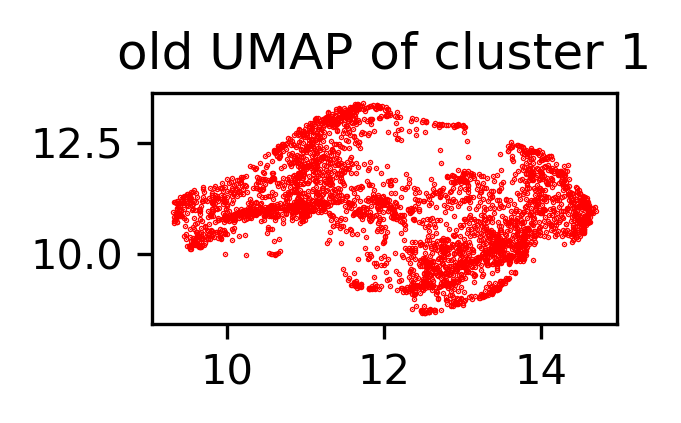

In [23]:
# just take cluster 6 and plot a new umap
cluster_ind = np.where(clusterer.labels_ == 7)[0]
cluster_old_umap =  umapAll[cluster_ind,:]
plt.figure(figsize=(2,1), dpi=300)
plt.scatter(cluster_old_umap[:, 0], cluster_old_umap[:, 1], s=0.1, c='r')
plt.title('old UMAP of cluster 1')

Text(0.5, 1.0, 'PCA of the data, balanced and zscored, 10 components, 2 dimensions')

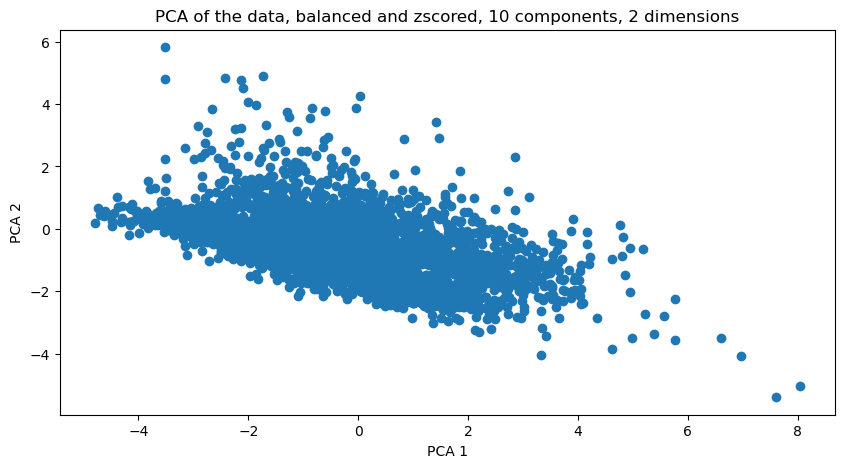

In [24]:
# but let's try making a new umap fit just based on this cluster
cluster_data = Z_PCA_Balanced_All[cluster_ind,:]

# plot it pca space
plt.figure(figsize=(10, 5))
plt.scatter(cluster_data[:,0], cluster_data[:,1], cmap = 'tab20')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of the data, balanced and zscored, 10 components, 2 dimensions')

/opt/miniconda3/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


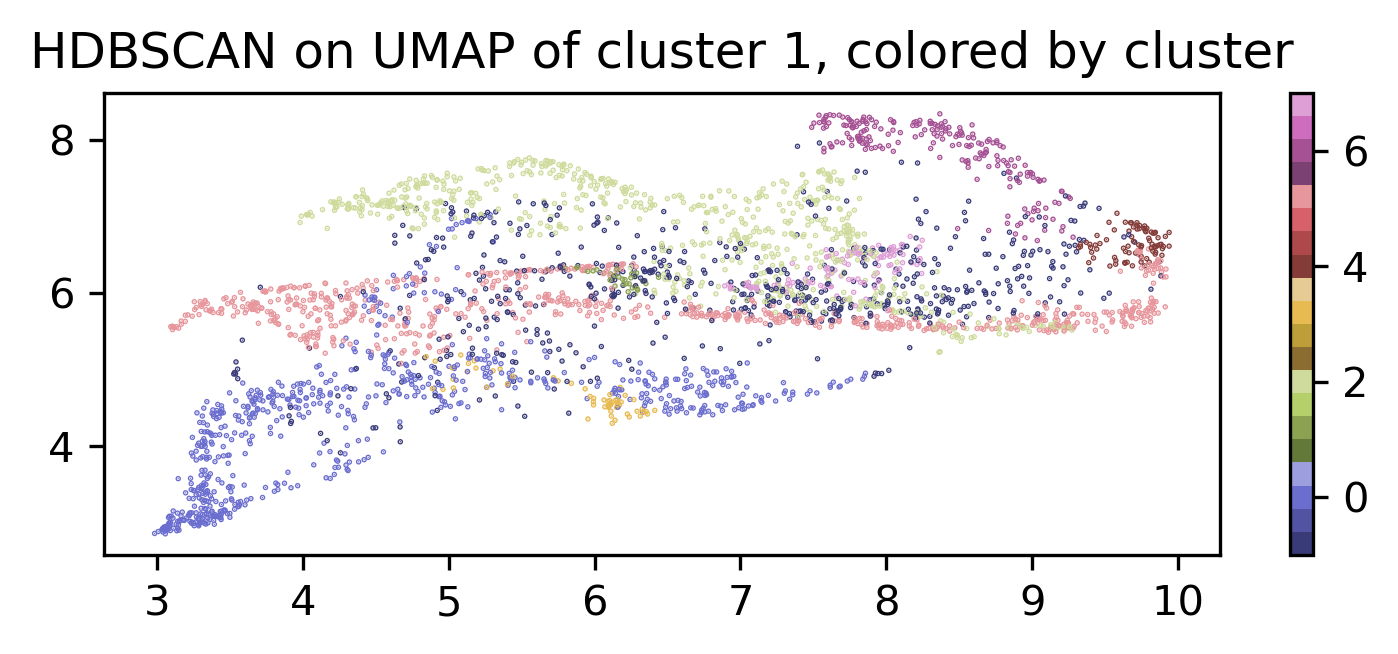

In [25]:
# make a new umap fit
umapFitCluster = umap.UMAP(
        n_neighbors=int(len(cluster_data)/MAXSYLL),
        min_dist=0.1,
        n_components=4,
        random_state=42).fit(cluster_data)

# project the data into the new umap
umapClusterData = umapFitCluster.transform(cluster_data)

# now let's cluster the cluster
min_cluster_size = 15
min_samples = 15
cluster_selection_epsilon = 0.4
clustererCluster = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, cluster_selection_epsilon=cluster_selection_epsilon)
clustererCluster.fit(umapClusterData)

# Plot the new umap with new clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapClusterData[:, 0], umapClusterData[:, 1], s=0.1, c=clustererCluster.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of cluster 1, colored by cluster')
plt.colorbar()



In [26]:
# print the number of calls in each cluster and the unclassified
print('Number of calls in each cluster and the unclassified')
print(Counter(clustererCluster.labels_))


Number of calls in each cluster and the unclassified
Counter({5: 757, 0: 716, 2: 710, -1: 596, 6: 208, 7: 114, 4: 80, 3: 63, 1: 32})


## ok, this looks good, let's update our original UMAP with the new cluster labels

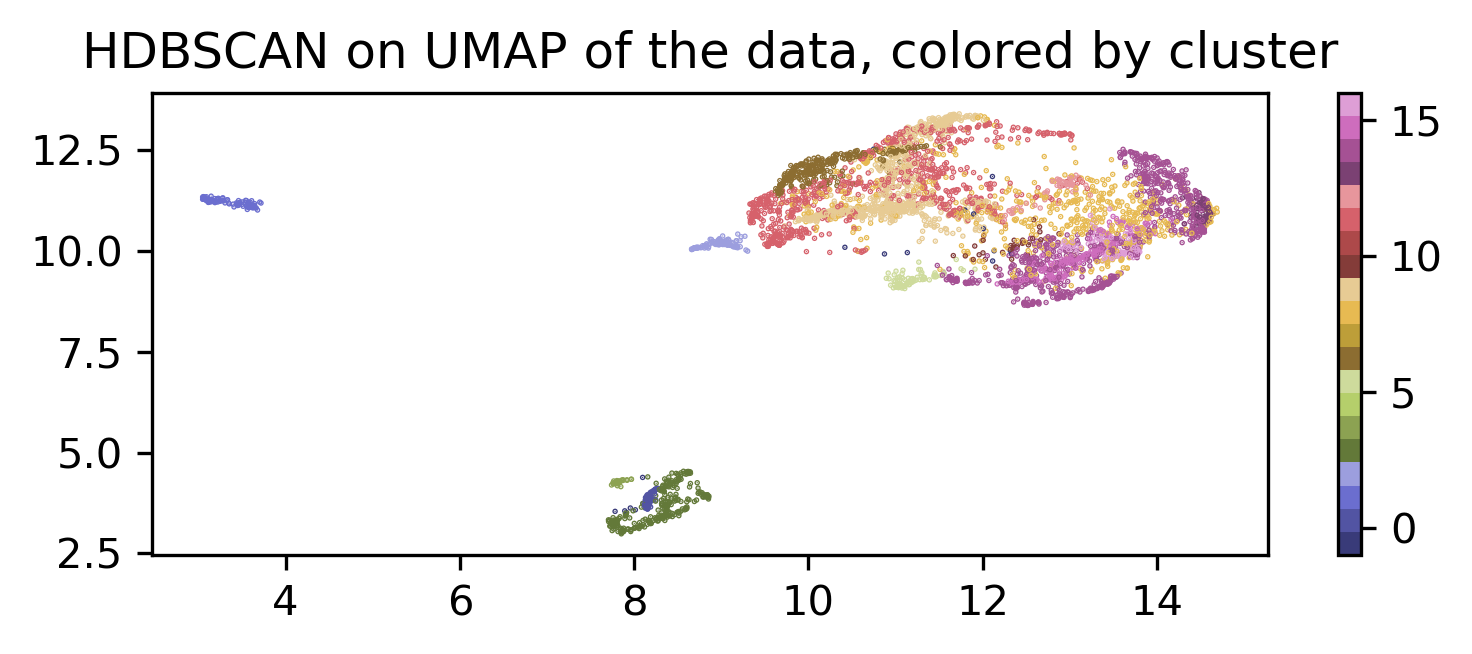

In [27]:
# update the cluster labels
clustererCluster.labels_ += np.max(clusterer.labels_) + 2
clusterer.labels_[cluster_ind] = clustererCluster.labels_
 
# Plot the clusters
plt.figure(figsize=(6,2), dpi=300)
plt.scatter(umapAll[:, 0], umapAll[:, 1], s=0.1, c=clusterer.labels_, cmap='tab20b')
plt.title('HDBSCAN on UMAP of the data, colored by cluster')
plt.colorbar()


In [28]:
vocSelTableFull

,Bird,project.start_index,calltype,fund,devfund,cvfund,maxfund,minfund,F1,F2,...,kurtT,entT,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster,callLength
0,WhiWhi6607F,1134,"[""0""]",602.035277,0.020312,0.123225,676.056338,480.000000,1927.151857,5606.097997,...,2.037413,0.966456,0,BroGre1354M,0,705034,709502,1,0.0,0.093083
1,BluGre1214F,951,"[""6""]",532.179639,0.659361,0.171370,592.592593,298.136646,1223.147592,4405.922739,...,1.941768,0.994068,1,BluGre1214F,2,739121,741816,6,5.0,0.056146
2,BluGre1214F,3202,"[""5""]",1004.070215,-1.918334,1.029701,3428.571429,539.325843,3282.440047,5674.842286,...,1.931446,0.993494,2,BluGre1214F,2,773851,776369,2,1.0,0.052458
3,WhiWhi6607F,2406,"[""6""]",606.338279,0.138851,0.031357,631.578947,564.705882,1153.195682,2492.185919,...,1.876354,0.998047,3,BluGre1214F,2,844891,848558,6,5.0,0.076396
4,BroGre1354M,311,"[""5""]",538.920136,0.645045,0.054985,564.705882,484.848485,2085.536237,3634.836575,...,1.929756,0.993356,4,BroGre1354M,0,910549,913839,5,4.0,0.068542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,WhiWhi1541M,264,"[""5""]",2759.790084,88.223783,0.410419,3428.571429,640.000000,3032.627721,4153.134038,...,2.214188,0.981780,4339,WhiWhi1541M,3,297302736,297305283,5,4.0,0.053062
4340,WhiWhi6607F,2596,"[""6""]",578.539703,-0.142540,0.253493,705.882353,342.857143,2424.752958,4687.304451,...,1.840979,0.998115,4340,BluGre1214F,2,297324812,297329004,6,5.0,0.087333
4341,WhiWhi6607F,2607,"[""6""]",549.876920,-0.126703,0.223594,640.000000,317.880795,1243.568203,2839.879516,...,1.913242,0.995226,4341,BluGre1214F,2,297367001,297371644,6,5.0,0.096729
4342,BluGre1214F,453,"[""6""]",553.899881,-2.095338,0.032359,578.313253,521.739130,2318.997973,4615.010937,...,1.831353,0.990856,4342,BluGre1214F,2,298070022,298074525,6,5.0,0.093812


In [29]:
# Ok these clusters look ok let's save them to the original df. 
# First we need to add the cluster labels to the original df
vocSelTableFull['new_clusters'] = -2 # add a new column to the df
vocSelTableFull['new_clusters'][indGood] = clusterer.labels_ + 1# add the cluster labels to the new column from the first clustering
vocSelTableFull['new_clusters'][indBad] = -2 # add the unclassified calls to the new column
print('unique new clusters:', np.unique(vocSelTableFull['new_clusters']))

print('Number of calls in each cluster and the unclassified')
print(Counter(vocSelTableFull['new_clusters']))


unique new clusters: [-2  0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17]
Number of calls in each cluster and the unclassified
Counter({15: 757, 10: 716, 12: 710, 9: 596, 7: 287, 4: 258, 16: 208, 17: 114, -2: 103, 3: 101, 2: 97, 6: 87, 1: 85, 14: 80, 13: 63, 11: 32, 5: 29, 0: 21})


/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_40933/3771552412.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indGood] = clusterer.labels_ + 1# add the cluster labels to the new column from the first clustering
/var/folders/s4/0pb__4_s30s067z6pcyln44h0000gn/T/ipykernel_40933/3771552412.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vocSelTableFull['new_clusters'][indBad] = -2 # add the unclassified calls to the new column


In [35]:
# yeah that looks fine. 
# to resave the segments.csv file with the new cluster labels we need to put the new cluster labels back into the segments.csv file
# first we need to get the start and stop indices of the calls that we have in the vocSelTableFull
# we can then use these to replace the cluster labels in the segments.csv file
# we can then save the segments.csv file back to the original location

import json
for i in range(len(vocSelTableFull)):
    start_index = vocSelTableFull['StartIndex'].iloc[i]
    stop_index = vocSelTableFull['StopIndex'].iloc[i]
    cluster_label = vocSelTableFull['new_clusters'].iloc[i]
    syllTable.loc[syllTable['StartIndex'] == start_index, 'Tags'] = json.dumps(list([str(cluster_label)]))

print(len(syllTable))
syllTable.to_csv(syll_file_name, index=False)

# vocSelTableFull.to_hdf(os.path.join(base_folder, 'vocSelTableAmp.h5'), 'callTable', mode = 'w')
# print('File saved to', os.path.join(base_folder, 'vocSelTableAmp.h5'))

4344


In [37]:
# you have to copy and paste these into the tags.csv file
# The unique tags
tags = np.unique(syllTable['Tags'])

# Copy and paste this output to tags.csv
print(',TagName')
i=0
for itag, tag in enumerate(tags):
    print('{},{}'.format(itag, tag[2:-2]))
    # print(tag)
    i+=1

# # Write Labelled file to disk
# syllTable.to_csv(syllableOut)
# print(len(syllTable))
# print(len(vocSelTableFull))

,TagName
0,-2
1,0
2,1
3,10
4,11
5,12
6,13
7,14
8,15
9,16
10,17
11,2
12,3
13,4
14,5
15,6
16,7
17,9


In [33]:
# # The unique tags
# tags = np.unique(segmentTable['Tags'])

# # Copy and paste this output to tags.csv
# print(',TagName')
# for itag, tag in enumerate(tags):
#     print('{},{}'.format(itag, tag[2:-2]))
    

,Unnamed: 0.1,Unnamed: 0,SourceName,SourceChannel,StartIndex,StopIndex,Tags,cluster
0,0,0,BroGre1354M,0,705034,709502,"[""1""]",0.0
1,1,1,BluGre1214F,2,739121,741816,"[""6""]",5.0
2,2,2,BluGre1214F,2,773851,776369,"[""2""]",1.0
3,3,3,BluGre1214F,2,844891,848558,"[""6""]",5.0
4,4,4,BroGre1354M,0,910549,913839,"[""5""]",4.0


In [38]:
project_dir = '/Users/williamwood/Documents/Data/Field Station Recordings/for_soundsep/14_38_03_18_07_2023'
seg_df = pd.read_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))
new_coords = umapAll.astype(float)    # n x 3 array
seg_df['Coords'] = None
seg_df.loc[indGood,'Coords'] = [json.dumps(list(x)) for x in new_coords]
seg_df.to_csv(os.path.join(project_dir,'_appdata/save/segments.csv'))

In [40]:
seg_df.Tags.unique()

array(['["-2"]', '["15"]', '["4"]', '["12"]', '["10"]', '["11"]', '["9"]',
       '["16"]', '["7"]', '["17"]', '["13"]', '["5"]', '["3"]', '["0"]',
       '["1"]', '["14"]', '["6"]', '["2"]'], dtype=object)

In [48]:
[set([t for t in json.loads(tag_str)]) for tag_str in seg_df.Tags.unique()]

[{'-2'},
 {'15'},
 {'4'},
 {'12'},
 {'10'},
 {'11'},
 {'9'},
 {'16'},
 {'7'},
 {'17'},
 {'13'},
 {'5'},
 {'3'},
 {'0'},
 {'1'},
 {'14'},
 {'6'},
 {'2'}]